* [1 Uncertainty Model](#UncertaintyModel)
    * [Cross-validation](#1CrossValidation)
    * [AR Parameter Optimization](#1ARParameterOptimization)
    * [Uncertainty Model](#1UncertaintyModel)
* [2 Decision Making](#DecisionMaking)
    * [Naive Strategy](#2NaiveStrategy)
    * [Robust Strategy](#2RobustStrategy)
    * [Affine Strategy](#2AffineStrategy)
* [3 Evaluation Metrics](#EvaluationMetrics)

In [1]:
import numpy as np
from cvxpy import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# load data.
beta = np.loadtxt("data/projectdata.txt")
# load test data.
test_data = np.loadtxt("data/test_data.txt")
more_test_data = np.genfromtxt("data/more_test_data.txt", delimiter=',')

# 1 Uncertainty Model <a id="UncertaintyModel"></a>

## Cross-validation<a id="1CrossValidation"></a>

In [3]:
def uncertainty_model_cv(beta, p):
    n = len(beta)
    # create the H matrix, split the traning and validation set
    H_all = np.zeros(p*n).reshape(n, p)
    for i in np.arange(p):
        H_all[:,i] = np.concatenate([np.zeros(i+1), beta[:-(i+1)]])
    beta_validation = beta[-6:]
    H_p = H_all[p:-6, :]
    H_validation = H_all[-6:, :]
    beta_p = beta[p:-6]
    # solve the optimization problem
    sigma_hat = Variable(1)
    theta_hat = Variable(p)
    prob = Problem(Minimize(sigma_hat), 
                   [norm(beta_p - H_p*theta_hat, "inf") <= sigma_hat,
                    sigma_hat > 0])
    prob.solve()
    # calculate the error
    error = H_validation.dot(np.array(theta_hat.value)).flatten()-\
    beta_validation
    # calculate the mean absolute error
    mae = sum(np.abs(error))/6
    n_excess_bound = sum(np.abs(error)-sigma_hat.value > 0)
    return sigma_hat.value, theta_hat.value, mae, n_excess_bound

In [4]:
maes = []
n_excess_bounds = []
for p in np.arange(1, 31):
    theta_hats_cv = []
    maes_cv = []
    n_excess_bounds_cv = []
    for cv in np.arange(10):
        if cv == 0:
            sigma_hat, theta_hat, mae, n_excess_bound = \
            uncertainty_model_cv(beta,p)
        else:
            sigma_hat, theta_hat, mae, n_excess_bound = \
            uncertainty_model_cv(beta[:-cv],p)
        maes_cv += [mae]
        n_excess_bounds_cv += [n_excess_bound]
    maes += [np.mean(maes_cv)]
    n_excess_bounds += [np.mean(n_excess_bounds_cv)/6]

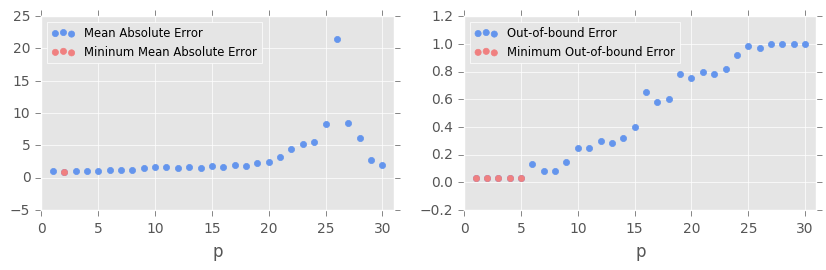

In [5]:
f, axarr = plt.subplots(1, 2, figsize=(10,2.5))
axarr[0].scatter(np.arange(1, 31), maes, 
                 label="Mean Absolute Error", 
                 color = "cornflowerblue")
axarr[0].scatter(np.arange(1, 31)[1], maes[1], 
                 color = "lightcoral", 
                 label="Mininum Mean Absolute Error")
axarr[0].legend(loc="upper left", fontsize = 'x-small')
axarr[0].set_xlim([0, 31])
axarr[0].legend(loc="upper left", fontsize = 'small')
axarr[0].set_xlabel('p')
axarr[1].scatter(np.arange(1, 31), n_excess_bounds, 
                 label="Out-of-bound Error", 
                 color = "cornflowerblue")
axarr[1].scatter(np.arange(1, 31)[:5], n_excess_bounds[:5], 
                 color = "lightcoral",
                 label="Minimum Out-of-bound Error")
axarr[1].set_xlim([0, 31])
axarr[1].legend(loc="upper left", fontsize = 'small')
axarr[1].set_xlabel('p')
f.savefig("report/cv.png")

## AR Parameter Optimization<a id="1ARParameterOptimization"></a>

We choose p=2 to fit our model.

In [6]:
def ar_opt(beta, p, return_beta_hat = False):
    n = len(beta)
    # create the H matrix
    H_p = np.zeros(p*n).reshape(n, p)
    for i in np.arange(p):
        H_p[:,i] = np.concatenate([np.zeros(i+1), beta[:-(i+1)]])
    beta_validation = beta[-6:]
    H_p = H_p[p:, :]
    beta_p = beta[p:]
    # solve the optimization problem
    sigma_hat = Variable(1)
    theta_hat = Variable(p)
    prob = Problem(Minimize(sigma_hat), 
                   [norm(beta_p - H_p*theta_hat, "inf") <= sigma_hat,
                    sigma_hat > 0])
    prob.solve()
    if (return_beta_hat):
        return [sigma_hat.value, np.asarray(theta_hat.value).flatten(), 
                np.asarray(H_p*theta_hat.value).flatten()]
    return [sigma_hat.value, np.asarray(theta_hat.value).flatten()]

In [7]:
sigma, theta, beta_hat = ar_opt(beta = beta, p = 2, return_beta_hat = True)

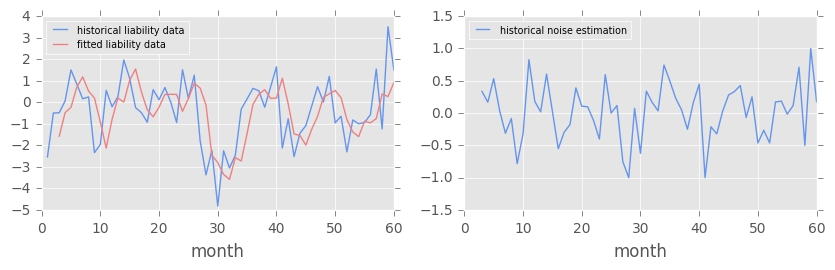

In [8]:
f, axarr = plt.subplots(1, 2, figsize=(10,2.5))
axarr[0].plot(np.arange(1, 61), beta, 
                 label="historical liability data", 
                 color = "cornflowerblue")
axarr[0].plot(np.arange(1 + 2, 61), beta_hat, 
                 label="fitted liability data", 
                 color = "lightcoral")
axarr[0].legend(loc="upper left", fontsize = 'x-small')
axarr[0].set_xlabel('month')
axarr[1].plot(np.arange(1 + 2, 61), (beta[2:]-beta_hat)/sigma, 
                 label="historical noise estimation", 
                 color = "cornflowerblue")
axarr[1].legend(loc="upper left", fontsize = 'x-small')
axarr[1].set_xlabel('month')
f.savefig("report/uncertaintyModel.png")

## Uncertainty Model<a id="1UncertaintyModel"></a>

In [9]:
def calc_beta_hat_B(sigma, theta, beta):
    theta_1 = theta[0]
    theta_2 = theta[1]
    beta_t_1 = beta[-2]
    beta_t = beta[-1]
    beta_t1 = np.array([theta_1, theta_2, sigma])
    beta_t2 = theta_1*np.concatenate([beta_t1, [0]]) + \
        theta_2*np.array([1, 0, 0, 0]) + \
        sigma*np.array([0, 0, 0, 1])
    beta_t3 = theta_1*np.concatenate([beta_t2, [0]]) + \
        theta_2*np.concatenate([beta_t1, [0, 0]]) + \
        sigma*np.array([0, 0, 0, 0, 1])
    beta_t4 = theta_1*np.concatenate([beta_t3, [0]]) + \
        theta_2*np.concatenate([beta_t2, [0, 0]]) + \
        sigma*np.array([0, 0, 0, 0, 0, 1])
    beta_t5 = theta_1*np.concatenate([beta_t4, [0]]) + \
        theta_2*np.concatenate([beta_t3, [0, 0]]) + \
        sigma*np.array([0, 0, 0, 0, 0, 0, 1])
    beta_t6 = theta_1*np.concatenate([beta_t5, [0]]) + \
        theta_2*np.concatenate([beta_t4, [0, 0]]) + \
        sigma*np.array([0, 0, 0, 0, 0, 0, 0, 1])
        
    b_hat = np.vstack([beta_t1[:2], beta_t2[:2], beta_t3[:2], 
                       beta_t4[:2], beta_t5[:2], beta_t6[:2]]).dot(
        np.array([beta_t, beta_t_1]))
    B = np.vstack([np.concatenate([beta_t1[2:], np.zeros(5)]),
                  np.concatenate([beta_t2[2:], np.zeros(4)]),
                  np.concatenate([beta_t3[2:], np.zeros(3)]),
                  np.concatenate([beta_t4[2:], np.zeros(2)]),
                  np.concatenate([beta_t5[2:], np.zeros(1)]),
                  beta_t6[2:]])
    return b_hat.reshape(6, 1), B

In [10]:
b_hat, B = calc_beta_hat_B(sigma, theta, beta)

In [11]:
b_hat

array([[ 2.53868639],
       [ 1.93268543],
       [ 2.22029883],
       [ 2.02661616],
       [ 2.09286371],
       [ 2.0194315 ]])

In [12]:
B

array([[ 3.24341243,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.45644363,  3.24341243,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 2.38187229,  1.45644363,  3.24341243,  0.        ,  0.        ,
         0.        ],
       [ 1.84546219,  2.38187229,  1.45644363,  3.24341243,  0.        ,
         0.        ],
       [ 2.09759205,  1.84546219,  2.38187229,  1.45644363,  3.24341243,
         0.        ],
       [ 1.9250487 ,  2.09759205,  1.84546219,  2.38187229,  1.45644363,
         3.24341243]])

# 2 Decision Making<a id="DecisionMaking"></a>

In [13]:
A = np.array([[  -1.,     0,     0,     0,     0,  0,    1.,     0,     0,    1.,     0,     0,     0,     0],
              [1.003,    -1,     0,     0,     0,  0,     0,    1.,     0, -1.01,    1.,     0,     0,     0],
              [    0, 1.003,    -1,     0,     0,  0,     0,     0,    1.,     0, -1.01,    1.,     0,     0],
              [    0,     0, 1.003,    -1,     0,  0, -1.02,     0,     0,     0,     0, -1.01,    1.,     0],
              [    0,     0,     0, 1.003,    -1,  0,     0, -1.02,     0,     0,     0,     0, -1.01,    1.],
              [    0,     0,     0,     0, 1.003, -1,     0,     0, -1.02,     0,     0,     0,     0, -1.01]])

## Naive Strategy<a id="2NaiveStrategy"></a>

In [14]:
def naive_strategy_jan(C_initial):
    C_initial_array = np.array([C_initial, 0, 0, 0, 0, 0]).reshape(6, 1)
    x_cash = Variable(6, 1)
    x_cp = Variable(3, 1)
    x_cre = Variable(5, 1)
    prob = Problem(Maximize(x_cash[5]), 
               [A*vstack(x_cash, x_cp, x_cre) + C_initial_array >= b_hat,
                x_cre <= 1, x_cre >=0, x_cp >= 0, x_cash >= 0])
    prob.solve()
    return x_cash.value, x_cp.value, x_cre.value

In [15]:
def naive_strategy(C_initial, b_hat, month, 
                   x_cash_previous, x_cp_previous, x_cre_previous):
    
    month_remaining = 6-month
    
    # we have already applied the strategy to the previous i-1 month 
    x_cash_previous = x_cash_previous[:(month-1), :] 
    x_cp_previous = x_cp_previous[:min(month-1, 3), :]
    x_cre_previous = x_cre_previous[:min(month-1, 5), :]
    
    C_initial_array = np.insert(np.zeros(month_remaining), 0, C_initial).reshape(month_remaining+1, 1)
    x_cash = Variable(6, 1)
    x_cp = Variable(3, 1)
    x_cre = Variable(5, 1)
    prob = Problem(Maximize(x_cash[5]), 
                   [A[(month-1):, :]*vstack(x_cash, x_cp, x_cre) + C_initial_array >= b_hat[:(month_remaining+1), :],
                    x_cre <= 1, x_cre >=0, x_cp >= 0, x_cash >= 0,
                    # we have already applied the strategy to the previous i-1 month 
                    x_cash[:(month-1), :] ==  x_cash_previous,
                    x_cp[:min([month-1, 3]), :] == x_cp_previous,
                    x_cre[:min([month-1, 5]), :] == x_cre_previous])
    prob.solve()
#     if month == 3:
#         import pdb; pdb.set_trace()
    return x_cash.value, x_cp.value, x_cre.value

In [16]:
def rolling_naive(C_initial, test_data, beta, verbose=False):
    sigma, theta = ar_opt(beta = beta, p = 2)
    b_hat, B = calc_beta_hat_B(sigma, theta, beta)
    if verbose:
        print("month 1:")
        print(b_hat)
    x_cash_previous, x_cp_previous, x_cre_previous = naive_strategy_jan(C_initial)
    
    for i in np.arange(5):
        C_initial = A[i, ]*np.vstack([x_cash_previous, x_cp_previous, x_cre_previous]) + C_initial - test_data[i]
        if verbose: 
            print("month", i+2)
            print(C_initial+test_data[i])
            print(C_initial)
        if (C_initial < 0):
            return False, 0
        beta = np.insert(beta, len(beta), test_data[i])
        sigma, theta = ar_opt(beta = beta, p = 2)
        b_hat, B = calc_beta_hat_B(sigma, theta, beta)
        if verbose: 
            print("b_hat: ")
            print(b_hat)
        x_cash_previous, x_cp_previous, x_cre_previous = naive_strategy(
            C_initial, b_hat, i+2, x_cash_previous, x_cp_previous, x_cre_previous)
        
    return True, x_cash_previous[-1, 0] + b_hat[0, 0] - test_data[5]
#     return x_cash.value, x_cp.value, x_cre.value

In [17]:
results_rolling_naive = []
results_rolling_naive += [rolling_naive(70.3, test_data, beta)]
for i in more_test_data:
    results_rolling_naive += [rolling_naive(70.3, i, beta, False)]

In [18]:
results_rolling_naive

[(False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (True, 70.266958161769821),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0),
 (False, 0)]

## Robust Strategy<a id="2RobustStrategy"></a>

In [19]:
def robust_strategy_jan(C_initial):
    C_initial_array = np.array([C_initial, 0, 0, 0, 0, 0]).reshape(6, 1)
    x_cash = Variable(6, 1)
    x_cp = Variable(3, 1)
    x_cre = Variable(5, 1)
    prob = Problem(Maximize(x_cash[5]), 
                   [A*vstack(x_cash, x_cp, x_cre) + C_initial_array >= \
                    b_hat + abs(B)*np.ones(6).T,
                    x_cre <= 1, x_cre >=0, x_cp >= 0, x_cash >= 0])
    prob.solve()
    return x_cash.value, x_cp.value, x_cre.value

In [20]:
def robust_strategy(C_initial, b_hat, month, B, 
                    x_cash_previous, x_cp_previous, x_cre_previous):
    
    month_remaining = 6-month
    
    # we have already applied the strategy to the previous i-1 month 
    x_cash_previous = x_cash_previous[:(month-1), :] 
    x_cp_previous = x_cp_previous[:min(month-1, 3), :]
    x_cre_previous = x_cre_previous[:min(month-1, 5), :]
    
    C_initial_array = np.insert(np.zeros(month_remaining), 0, C_initial).reshape(month_remaining+1, 1)
    x_cash = Variable(6, 1)
    x_cp = Variable(3, 1)
    x_cre = Variable(5, 1)
    prob = Problem(Maximize(x_cash[5]), 
                   [A[(month-1):, :]*vstack(x_cash, x_cp, x_cre) + C_initial_array >= \
                    (b_hat + abs(B)*np.ones(6).T)[:(month_remaining+1), :],
                    x_cre <= 1, x_cre >=0, x_cp >= 0, x_cash >= 0,
                    # we have already applied the strategy to the previous i-1 month 
                    x_cash[:(month-1), :] ==  x_cash_previous,
                    x_cp[:min([month-1, 3]), :] == x_cp_previous,
                    x_cre[:min([month-1, 5]), :] == x_cre_previous])
    prob.solve()
#     if month == 3:
#         import pdb; pdb.set_trace()
    return x_cash.value, x_cp.value, x_cre.value

In [21]:
def rolling_robust(C_initial, test_data, beta, verbose=False):
    sigma, theta = ar_opt(beta = beta, p = 2)
    b_hat, B = calc_beta_hat_B(sigma, theta, beta)
    if verbose:
        print("month 1:")
        print(b_hat)
    x_cash_previous, x_cp_previous, x_cre_previous = robust_strategy_jan(C_initial)
    
    for i in np.arange(5):
        C_initial = A[i, ]*np.vstack([x_cash_previous, x_cp_previous, x_cre_previous]) + C_initial - test_data[i]
        if verbose: 
            print("month", i+2)
            print(C_initial+test_data[i])
            print(C_initial)
        if (C_initial < 0):
            return False, 0
        beta = np.insert(beta, len(beta), test_data[i])
        sigma, theta = ar_opt(beta = beta, p = 2)
        b_hat, B = calc_beta_hat_B(sigma, theta, beta)
        if verbose: 
            print("b_hat: ")
            print(b_hat)
        x_cash_previous, x_cp_previous, x_cre_previous = robust_strategy(
            C_initial, b_hat, i+2, B, x_cash_previous, x_cp_previous, x_cre_previous)
        
    return True, x_cash_previous[-1, 0] + b_hat[0, 0] - test_data[5]
#     return x_cash.value, x_cp.value, x_cre.value

In [22]:
results_rolling_robust = []
results_rolling_robust += [rolling_robust(70.3, test_data, beta)]
for i in more_test_data:
    results_rolling_robust += [rolling_robust(70.3, i, beta, False)]

In [23]:
results_rolling_robust

[(True, 63.844405149128214),
 (True, 66.929212020013409),
 (True, 71.594107406126554),
 (True, 65.81812784445431),
 (True, 67.571157461245804),
 (True, 69.36569858591254),
 (True, 70.228694068890064),
 (True, 62.254453667903711),
 (True, 75.171301599215383),
 (True, 60.746050941659831),
 (True, 63.677342564972655),
 (True, 66.436371112397694),
 (True, 70.307614943202921),
 (True, 65.696961050714904),
 (True, 64.556972002906264),
 (True, 66.974601821575362),
 (True, 62.810073649025945),
 (True, 68.308289750975746),
 (True, 63.80976852320628),
 (True, 62.999274973210959),
 (True, 67.484170354837374)]

## Affine Strategy<a id="2AffineStrategy"></a>

In [24]:
def affine_strategy_jan(C_initial):
    C_initial_array = np.array([C_initial, 0, 0, 0, 0, 0]).reshape(6, 1)
    x_cash = Variable(6, 1)
    x_cp = Variable(3, 1)
    x_cre = Variable(5, 1)
    X_Cash = Variable(6, 6)
    X_Cp = Variable(3, 6)
    X_Cre = Variable(5, 6)
    
    constraints = [A*vstack(x_cash,x_cp,x_cre) + C_initial_array >= \
                   b_hat + \
                   sum_entries(abs(B - A*vstack(X_Cash,X_Cp,X_Cre)), axis=1),
                   vstack(x_cash,x_cp,x_cre) >= \
                   sum_entries(abs(vstack(X_Cash,X_Cp,X_Cre)), axis=1),
                   x_cre + sum_entries(abs(X_Cre), axis=1) <= 1]
    
    for i in range(6):
        constraints += [X_Cash[i, i:] == 0]
    for i in range(3):
        constraints += [X_Cp[i, i:] == 0]
    for i in range(5):
        constraints += [X_Cre[i, i:] == 0]

    prob = Problem(Maximize(x_cash[5]-sum(abs(X_Cash[-1, :]))), 
               constraints)
    prob.solve()
    
    return x_cash.value, x_cp.value, x_cre.value

In [25]:
def affine_strategy(C_initial, b_hat, month, B, 
                    x_cash_previous, x_cp_previous, x_cre_previous):
    
    month_remaining = 6-month
    
    # we have already applied the strategy to the previous i-1 month 
    x_cash_previous = x_cash_previous[:(month-1), :] 
    x_cp_previous = x_cp_previous[:min(month-1, 3), :]
    x_cre_previous = x_cre_previous[:min(month-1, 5), :]
    
    C_initial_array = np.insert(np.zeros(month_remaining), 0, C_initial).reshape(month_remaining+1, 1)
    x_cash = Variable(6, 1)
    x_cp = Variable(3, 1)
    x_cre = Variable(5, 1)
    X_Cash = Variable(6, 6)
    X_Cp = Variable(3, 6)
    X_Cre = Variable(5, 6)
    
    constraints = [A[(month-1):, :]*vstack(x_cash,x_cp,x_cre) + C_initial_array >= \
                   b_hat[:(month_remaining+1), :] + \
                   sum_entries(abs(B - A*vstack(X_Cash,X_Cp,X_Cre)), axis=1)[:(month_remaining+1), :],
                   vstack(x_cash,x_cp,x_cre) >= \
                   sum_entries(abs(vstack(X_Cash,X_Cp,X_Cre)), axis=1),
                   x_cre + sum_entries(abs(X_Cre), axis=1) <= 1,
                    # we have already applied the strategy to the previous i-1 month 
                    x_cash[:(month-1), :] ==  x_cash_previous,
                    x_cp[:min([month-1, 3]), :] == x_cp_previous,
                    x_cre[:min([month-1, 5]), :] == x_cre_previous]
    
    for i in range(6):
        constraints += [X_Cash[i, i:] == 0]
    for i in range(3):
        constraints += [X_Cp[i, i:] == 0]
    for i in range(5):
        constraints += [X_Cre[i, i:] == 0]
        
    constraints += [vstack(X_Cash,X_Cp,X_Cre)[:, :(month-1)] == 0]

    prob = Problem(Maximize(x_cash[5]-sum(abs(X_Cash[-1, :]))), 
               constraints)
    prob.solve()
    
    return x_cash.value, x_cp.value, x_cre.value

In [26]:
def rolling_affine(C_initial, test_data, beta, verbose=False):
    sigma, theta = ar_opt(beta = beta, p = 2)
    b_hat, B = calc_beta_hat_B(sigma, theta, beta)
    if verbose:
        print("month 1:")
        print(b_hat)
    x_cash_previous, x_cp_previous, x_cre_previous = affine_strategy_jan(C_initial)
    
    for i in np.arange(5):
        C_initial = A[i, ]*np.vstack([x_cash_previous, x_cp_previous, x_cre_previous]) + C_initial - test_data[i]
        if verbose: 
            print("month", i+2)
            print(C_initial+test_data[i])
            print(C_initial)
        if (C_initial < 0):
            return False, 0
        beta = np.insert(beta, len(beta), test_data[i])
        sigma, theta = ar_opt(beta = beta, p = 2)
        b_hat, B = calc_beta_hat_B(sigma, theta, beta)
        if verbose: 
            print("b_hat: ")
            print(b_hat)
        x_cash_previous, x_cp_previous, x_cre_previous = affine_strategy(
            C_initial, b_hat, i+2, B, x_cash_previous, x_cp_previous, x_cre_previous)
        
    return True, x_cash_previous[-1, 0] + b_hat[0, 0] - test_data[5]
#     return x_cash.value, x_cp.value, x_cre.value

In [27]:
rolling_rolling_affine = []
rolling_rolling_affine += [rolling_affine(70.3, test_data, beta)]
for i in more_test_data:
    rolling_rolling_affine += [rolling_affine(70.3, i, beta, False)]

In [28]:
rolling_rolling_affine

[(True, 63.844404774169845),
 (True, 66.929211561807861),
 (True, 71.594106754601057),
 (True, 65.818127333663824),
 (True, 67.571157088066713),
 (True, 69.365698024303512),
 (True, 70.228693671196027),
 (True, 62.25445327636622),
 (True, 75.171301054996036),
 (True, 60.746050741967615),
 (True, 63.67734204642327),
 (True, 66.43637054492325),
 (True, 70.30761474826096),
 (True, 65.696960619118215),
 (True, 64.556971513619672),
 (True, 66.974601454059467),
 (True, 62.810073277178532),
 (True, 68.308289554307336),
 (True, 63.809768135453972),
 (True, 62.999274489537953),
 (True, 67.484169747308485)]

# 3 Evaluation Metrics<a id="EvaluationMetrics"></a>

In [29]:
def test(test):    
    C_initial = 70.3
    C_initial_array = np.array([C_initial, 0, 0, 0, 0, 0]).reshape(6, 1)
    x_cash = Variable(6, 1)
    x_cp = Variable(3, 1)
    x_cre = Variable(5, 1)
    prob = Problem(Maximize(x_cash[5]), 
               [A*vstack(x_cash, x_cp, x_cre) + C_initial_array >= test,
                x_cre <= 1, x_cre >=0, x_cp >= 0, x_cash >= 0])
    prob.solve()
    return x_cash.value, x_cp.value, x_cre.value

In [30]:
optimal = []
optimal += [test(test_data)[0][5, 0]]
for i in more_test_data:
    optimal += [test(i)[0][5, 0]]

In [31]:
naive_regret = np.asarray(optimal) - np.asarray([i[1] for i in results_rolling_naive])
robust_regret = np.asarray(optimal) - np.asarray([i[1] for i in results_rolling_robust])
affine_regret = np.asarray(optimal) - np.asarray([i[1] for i in rolling_rolling_affine])

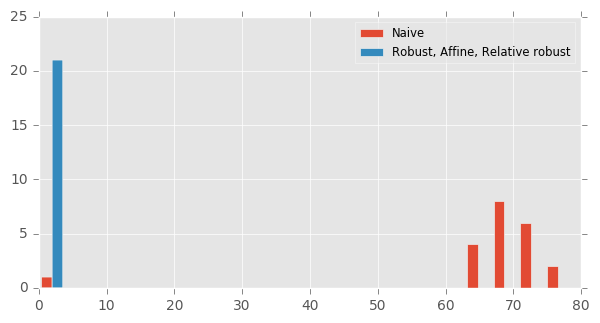

In [32]:
plt.figure(figsize=(7,3.5))
plt.hist([naive_regret, robust_regret], 
         20, histtype='bar', 
         label=["Naive", "Robust, Affine, Relative robust"])
# plt.title('Regret histogram of more test data')
plt.legend(loc="upper right", fontsize = 'small', framealpha=0.5)
plt.ylim(0, 25)
plt.savefig("report/rolling_regret.png")